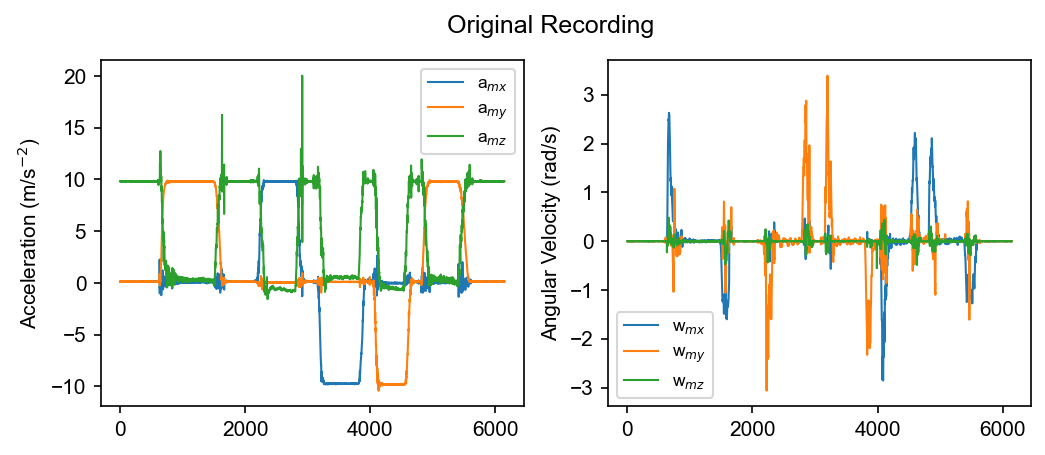

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

fs = 100 # sampling frequency

acc = pd.read_csv('./data/Accelerometer_Phone_Rotation.csv').iloc[:, 1:].to_numpy()
gyr = pd.read_csv('./data/Gyroscope_Phone_Rotation.csv').iloc[:, 1:].to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(8,3), dpi=150)
fig.suptitle('Original Recording')
ax[0].plot(acc, lw=1, label=['a$_{mx}$', 'a$_{my}$', 'a$_{mz}$'])
ax[1].plot(gyr, lw=1, label=['w$_{mx}$', 'w$_{my}$', 'w$_{mz}$'])
ax[0].legend(fontsize='small')
ax[0].set_ylabel('Acceleration (m/s$^{-2}$)')
ax[1].legend(fontsize='small')
ax[1].set_ylabel('Angular Velocity (rad/s)')
plt.show()

# Test dynamic Gravity Removal

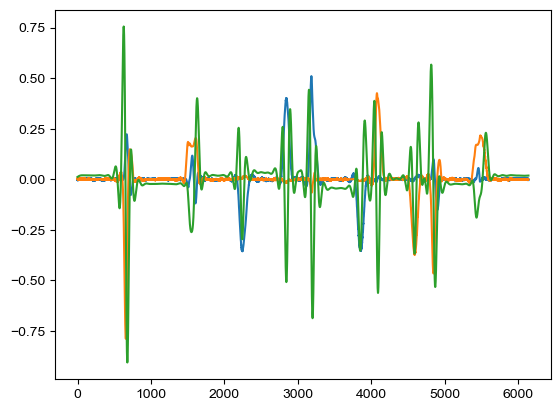

In [2]:
from signal_processing import bwfilt
from orientation import get_linear_acceleration
acc_f, gyr_f = bwfilt(acc, 4, 1, fs), bwfilt(gyr, 4, 1, fs)
a_I = get_linear_acceleration(a_m=acc_f, w_m=gyr_f, fs=fs, g_global=np.array([0, 0, 9.81]))
plt.plot(a_I)
plt.show()

### I can see from here that there is something wrong with the initial orientation, as the acceleration should be 0
#### Need to apply Rodrigues Rotation Formula

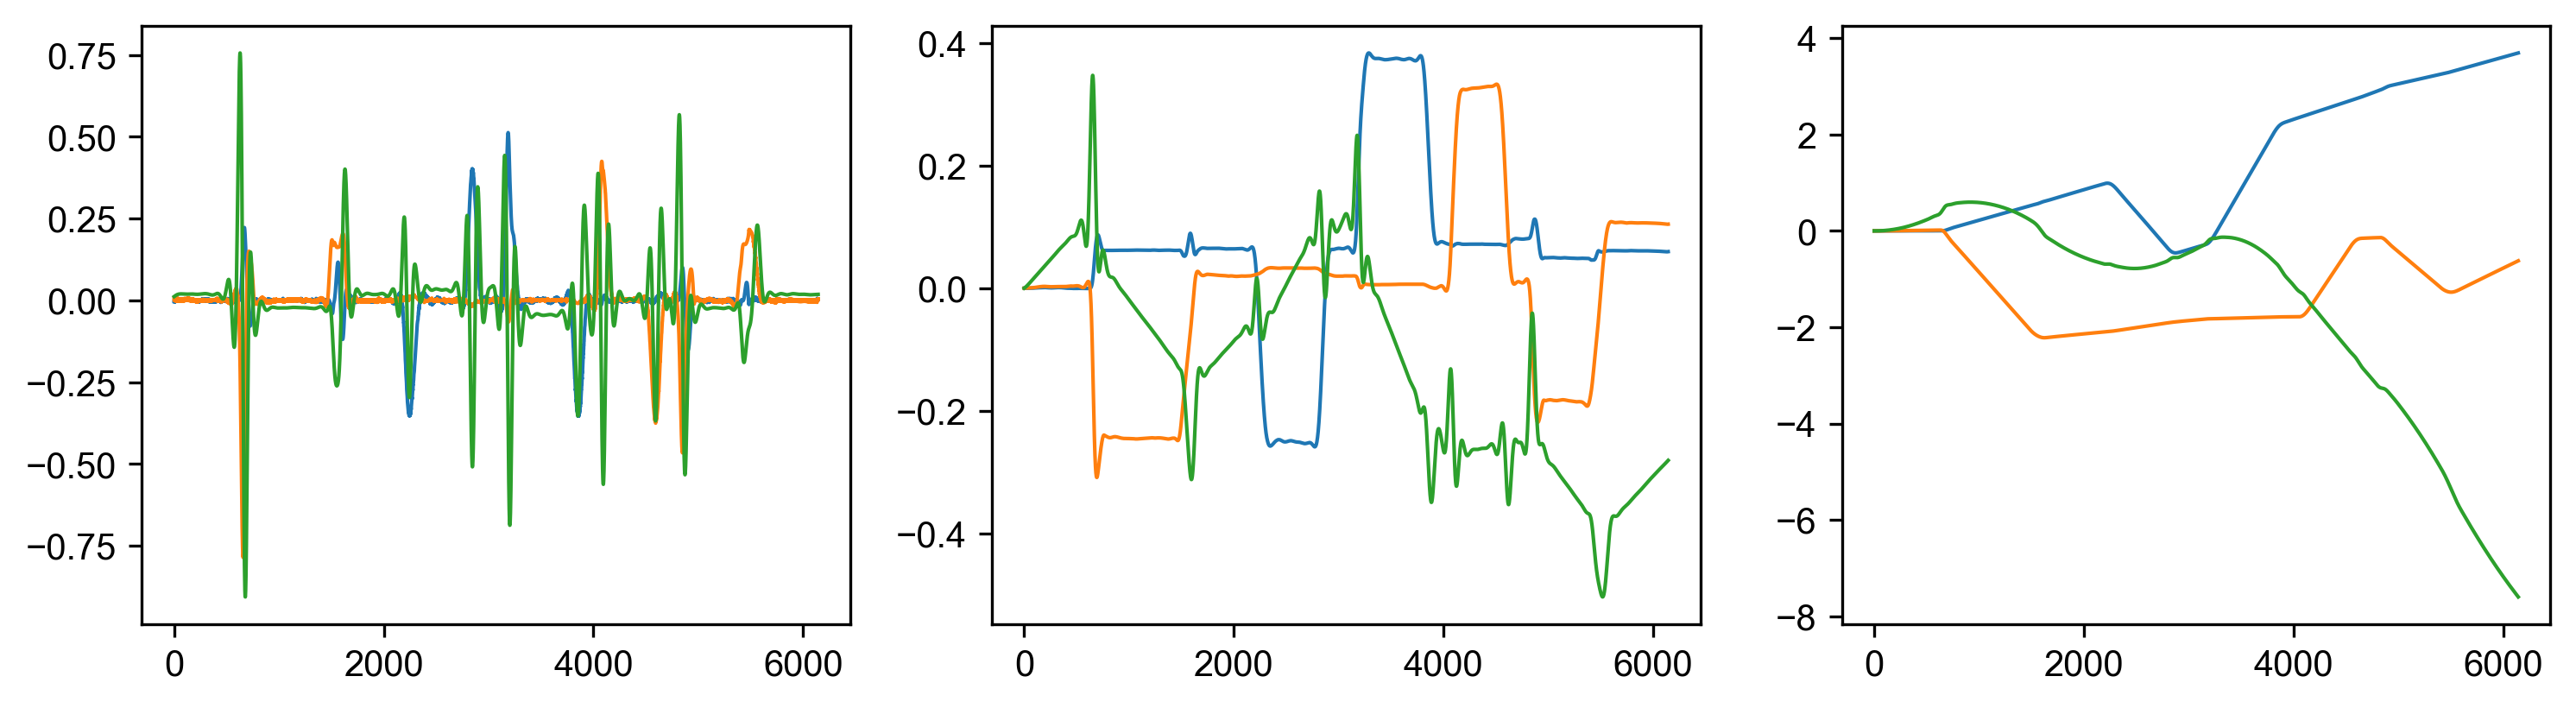

In [7]:
from orientation import rodrigues_rotation
from signal_processing import integrate_ndim

g_global = np.array([0, 0, 9.81])
g_sensor = np.mean(acc[:100, :], axis=0)
R = rodrigues_rotation(g_sensor=g_sensor, g_global=g_global)

a_m = (R @ acc.T).T
w_m = (R @ gyr.T).T
w_m -= np.mean(w_m[:100, :], axis=0) # Remove gyroscope bias as well

a_m, w_m = bwfilt(a_m, 4, 1, fs), bwfilt(w_m, 4, 1, fs)

a_I = get_linear_acceleration(a_m=a_m, w_m=w_m, fs=fs, g_global=g_global)
v_I = integrate_ndim(y_prime=a_I, fs=fs)
d_I = integrate_ndim(y_prime=v_I, fs=fs)
_, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=300)
ax[0].plot(a_I, lw=1)
ax[1].plot(v_I, lw=1)
ax[2].plot(d_I, lw=1)
plt.show()


In [31]:
def dcm2eul(R=None, seq=None):
    '''
    Computes the Euler angles from a Rotation Matrix. 
    '''
    # These are the 12 allowed sequences of rotations
    allowed_sequences = ('XYX', 'YXY', 'ZXZ', 'XZX', 'YZY', 'ZYZ', # Proper Euler Angles
                         'XYZ', 'XZY', 'YXZ', 'YZX', 'ZXY', 'ZYX') # Tait-Bryan Angles (RPY)
    
    if seq in allowed_sequences:
        r11, r12, r13 = R[0]
        r21, r22, r23 = R[1]
        r31, r32, r33 = R[2]
        eul = np.zeros(3)

        if seq == 'XYZ':
            eul[0] = np.arctan2(r33, -r23)
            eul[1] = np.arctan2(np.sqrt(1-r13**2), r13)
            eul[2] = np.arctan2(r11, -r12)
        
        if seq == 'XZY':
            eul[0] = np.arctan2(r22, r32)
            eul[1] = np.arctan2(np.sqrt(1-r12**2), -r12)
            eul[2] = np.arctan2(r11, r13)

        if seq == 'XYX':
            eul[0] = np.arctan2(-r31 , r21)
            eul[1] = np.arctan2(r11 , np.sqrt(1-r11**2))
            eul[2] = np.arctan2(r13 , r12)

        if seq == 'XZX':
            eul[0] = np.arctan2(r21, r31)
            eul[1] = np.arctan2(r11, np.sqrt(1-r11**2))
            eul[2] = np.arctan2(-r12, r13)

        if seq == 'YXZ':
            eul[0] = np.arctan2(r33, r31)
            eul[1] = np.arctan2(np.sqrt(1-r23**2), -r23)
            eul[2] = np.arctan2(r22, r21)

        if seq == 'YZX':
            eul[0] = np.arctan2(r11, -r31)
            eul[1] = np.arctan2(np.sqrt(1-r21**2), r21)
            eul[2] = np.arctan2(r22, -r23)

        if seq == 'YXY':
            eul[0] = np.arctan2(r32, r12)
            eul[1] = np.arctan2(r22, np.sqrt(1-r22**2))
            eul[2] = np.arctan2(-r23, r21)

        if seq == 'YZY':
            eul[0] = np.arctan2(-r12, r32)
            eul[1] = np.arctan2(r22, np.sqrt(1-r22**2))
            eul[2] = np.arctan2(r21, r23)

        if seq == 'ZXY':
            eul[0] = np.arctan2(r22, -r12)
            eul[1] = np.arctan2(np.sqrt(1-r32**2), r32)
            eul[2] = np.arctan2(r33, -r31)

        if seq == 'ZYX':
            eul[0] = np.arctan2(r11, r21)
            eul[1] = np.arctan2(np.sqrt(1-r31**2), -r31)
            eul[2] = np.arctan2(r33, r32)
   
        if seq == 'ZXZ':
            eul[0] = np.arctan2(-r23, r13)
            eul[1] = np.arctan2(r33, np.sqrt(1-r33**2))
            eul[2] = np.arctan2(r32, r31)

        if seq == 'ZYZ':
            eul[0] = np.arctan2(r13, r23)
            eul[1] = np.arctan2(r33, np.sqrt(1-r33**2))
            eul[2] = np.arctan2(-r31, r32)

    else:
        print(f'Wrong sequence. The argument must be one among the following:\n{allowed_sequences}')
        eul = None
    
    return eul

In [33]:
# These are the 12 allowed sequences of rotations
allowed_sequences = ('XYX', 'YXY', 'ZXZ', 'XZX', 'YZY', 'ZYZ', # Proper Euler Angles
                     'XYZ', 'XZY', 'YXZ', 'YZX', 'ZXY', 'ZYX') # Tait-Bryan Angles (RPY)

R = np.array([
             [1, 0, 0],
             [0, 1, 0],
             [0, 0, 1]
             ])

for seq in allowed_sequences:
    eul = dcm2eul(R, seq=seq)
    print(seq, f'{np.int32(np.degrees(eul))}')

XYX [ 0 90  0]
YXY [ 0 90  0]
ZXZ [ 0 90  0]
XZX [ 0 90  0]
YZY [ 0 90  0]
ZYZ [ 0 90  0]
XYZ [90 90 90]
XZY [90 90 90]
YXZ [90 90 90]
YZX [90 90 90]
ZXY [90 90 90]
ZYX [90 90 90]


In [ ]:
R = np.eye(3)



array([1., 0., 0.])